In [2]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from matplotlib import lines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

In [3]:
listNames = ['Khulan','Adrian','Mathilde','Virgil','FannyM','Margaux','JL','Hélène','Luca','Brice','ThiMai','Ani','Romain','StephB']
_type=['Grasshopper', 'Hybrid', 'Plugin']
niv=['No experience','Novice','Limited','Basic','Advanced','Expert']

In [4]:
def context_reorder(data, choice):
    context_grasshopper = data[(data["Object"]>1.1) & (data["Object"]<2)]
    context_hybrid = data[(data["Object"]>2.1) & (data["Object"]<3)]
    context_plugin = data[(data["Object"]>3.1) & (data["Object"]<4)]
    order1=context_grasshopper.index[0]
    order2=context_hybrid.index[0]
    order3=context_plugin.index[0]
    _order=[x for _, x in sorted(zip([order1, order2, order3], [1, 2, 3]))]
    if choice==0:
        return [context_grasshopper,context_hybrid,context_plugin], ['Grasshopper','Hybrid','Plugin'], _order
    elif choice==1:
        return context_grasshopper,'Grasshopper'
    elif choice==2:
        return context_hybrid,'Hybrid'
    elif choice==3:
        return context_plugin,'Plugin'
def sub_selection(_context, choice):
    facade_choice=choice
    if facade_choice==0:
        return _context
    return _context[_context["Object"] % 1 - (choice / 10) < 0.1]
def diff_analysis(_context):
    _diff=(_context.diff(1, 0) != 0)
    _diff.iloc[0]=False
    _diff['Time']=_context['Time']
    return _diff
def timeconvert(time):
    hours=int(time / 3600)
    minutes=int((time - hours * 3600) / 60)
    seconds=int(time - hours * 3600 - minutes * 60)
    return datetime.time(hours,minutes,seconds)
def time_to_sec(time):
    return (time.second + time.minute * 60 + time.hour * 3600) / 60
def split_profile(_df, _imp):
    prof1=pd.DataFrame()
    prof2=pd.DataFrame()
    prof3=pd.DataFrame()
    _profile = profile.loc[_df.index]
    score=_profile[_imp]
    it=0
    for x in score:     
        if int(x)==0:
            prof1=prof1.append(_df.iloc[it])
        if int(x)==1:
            prof2=prof2.append(_df.iloc[it])
        if int(x)==2:
            prof3=prof3.append(_df.iloc[it])
        it+=1
    return prof1.T,prof2.T,prof3.T

def plot_feedback(ax, a, _feedback_df):
    if a is None:
        pass
    else:
        _feedback_df=_feedback_df[_feedback_df['Order'] == a]
    colors=_feedback_df['Level'].map(lambda x:_color[int(x)])
    _feedback_df['Level']=_feedback_df['Level'].map(lambda x:niv[int(x)])
    color_set=colors.drop_duplicates().to_list()
    ax.set_autoscaley_on(False)
    ax.set_ybound(0,11)
    r=sns.pointplot(x='variable', y='value', data=_feedback_df[_feedback_df['Survey'] == 'A'], hue='Level', ci='sd', dodge=0.3, palette=color_set, markers='x', ax=ax, linestyles='--')

    _lines=r.get_lines()
    for line in _lines[:]:
        line.set_alpha(0.6)
        line.set_linewidth(1.5)
        line.set_zorder(1)

    sns.pointplot(x='variable', y='value', data=_feedback_df[_feedback_df['Survey'] == 'B'], hue='Level', ci='sd', dodge=0.3, palette=color_set.to_list(), ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    if a is not None:
        ax.set_xticklabels("")
    ax.get_legend().remove()
    return
def interaction_line_plot(_ax, result, _order, keep_list):
    int1=result[result.index.get_level_values('Order') == _order]
    _min=int1.min()
    _max=int1.max()
    _mean1=int1.mean()
    int1.drop(keep_list, axis=1, inplace=True)
    colors=int1['Level'].map(lambda x:_color[int(x)])
    int1['Level']=int1['Level'].map(lambda x:niv[int(x)])
    color_set=colors.drop_duplicates().to_list()
    int1=int1.melt(id_vars=['Level'])
    sns.pointplot(x=int1['variable'],y=int1['value'],data=int1,hue=int1['Level'],palette=color_set,ax=_ax,ci='sd',dodge=0.2)
    _ax.set_title('Interaction ' + str(_order + 1), loc='left', pad=3)
    _ax.set_ylabel(None)
    _ax.set_xlabel(None)
    _ax.tick_params(axis='y',pad=-1)
    _ax.legend(loc='upper right',title='Level')
    _ax.set_xticklabels("")
    return int1
def box_plot(ax, c, r, keep_list):
    r=r[[keep_list[c], 'Level']]
    r=r.reset_index('Order',drop=False)
    r2=r.copy()
    color_palette=sns.mpl_palette('RdYlBu_r',3)
    color_palette.append('gray')
    r2['Order']=3
    r=r.append(r2)
    sns.boxplot(ax=ax, y='Order', x=keep_list[c], data=r, orient='h', hue='Order', dodge=False, palette=color_palette)
    sns.swarmplot(ax=ax, y='Order', x=keep_list[c], data=r, orient='h', hue='Level', palette='Paired', dodge=True, s=10, marker='x', linewidth=3)
    ax.set_title(keep_list[c], loc='center', pad=3)
    ax.get_legend().remove()
    ax.set_ylabel(None)
    ax.set_yticklabels(['Interaction 1','Interaction 2','Interaction 3','Average'])
    return
def time_level_plot(_df, df_level, order_choice, ax, regression_order):
        if order_choice is None:
            _df=_df.droplevel('Order')
            level_list=df_level
        else:
            _df=_df.xs(order_choice, level='Order')
            level_list=df_level[order_choice]
        for lvl in level_list:
            level_df=_df.xs(lvl,level='Level').melt().applymap(lambda x:int(x))
            sns.regplot(x='variable', y='value', data=level_df, color=_color[lvl], ax=ax, order=regression_order, x_estimator=np.mean, scatter=False, ci=None)
        ax.set_ylabel(None)
        ax.set_xticklabels("")
        ax.set_xlabel(None)
        ax.tick_params(axis='y',pad=-1)
        return

In [5]:
survey=pd.read_excel("Enquete.xlsx")
survey['Nom']=listNames
intro= survey.iloc[:, [4, 7, 10, 16]]
subject_level_df= survey.iloc[:, [4, 21, 24, 27, 30, 33, 36, 39, 42]]
detail= survey.iloc[:, [4, 45, 48]]
interaction1_feedback= survey.iloc[:, [4, 51, 54, 57, 60, 63]]
interaction1_feedback.set_index('Nom', inplace=True)
interaction2_feedback= survey.iloc[:, [4, 69, 72, 75, 78, 81]]
interaction2_feedback.set_index('Nom', inplace=True)
interaction3_feedback= survey.iloc[:, [4, 87, 90, 93, 96, 99]]
interaction3_feedback.set_index('Nom', inplace=True)
posteriori_interaction1_feedback= survey.iloc[:, [4, 105, 108, 111, 114, 117]]
posteriori_interaction1_feedback.set_index('Nom', inplace=True)
posteriori_interaction2_feedback= survey.iloc[:, [4, 123, 126, 129, 132, 135]]
posteriori_interaction2_feedback.set_index('Nom', inplace=True)
posteriori_interaction3_feedback= survey.iloc[:, [4, 141, 144, 147, 150, 153]]
posteriori_interaction3_feedback.set_index('Nom', inplace=True)
col=interaction1_feedback.columns
interaction2_feedback.columns=col
interaction3_feedback.columns=col
posteriori_interaction1_feedback.columns=col
posteriori_interaction2_feedback.columns=col
posteriori_interaction3_feedback.columns=col
interaction_feedback=[interaction1_feedback, interaction2_feedback, interaction3_feedback]
posteriori_interaction_feedback=[posteriori_interaction1_feedback, posteriori_interaction2_feedback, posteriori_interaction3_feedback]
def convert_subject_level(n):
        _level=["Aucune expérience","Novice","Limité","Habitué","Avancé","Expert"]
        return _level.index(n)

subject_level_df.set_index('Nom', inplace=True)
subject_level_df=subject_level_df.applymap(convert_subject_level)
subject_level_df['Tot']=subject_level_df[['Rhino', 'Grasshopper']].mean(axis=1).round(0).convert_dtypes(convert_integer=True)
subject_level_df['Tot'].quantile(q=0.5)
def profile(n):
    low=n.quantile(q=0.33)
    high=n.quantile(q=0.66)
    p=[]
    for x in n:
        if x <= low:
            p.append(0)
        elif low<x<=high:
            p.append(1)
        elif high<x:
            p.append(2)
    return p
    

profile=subject_level_df.apply(profile, axis=0)

In [6]:
iterations_df=pd.DataFrame()
time_iterations_df=pd.DataFrame()
time_phases_df=pd.DataFrame()
time_unique_df=pd.DataFrame()
phase_df=pd.DataFrame()
unique_df=pd.DataFrame()
feedback_df=pd.DataFrame()
for name in listNames:
    path = name + '/' + name +'.csv'
    test = pd.read_csv(path,sep=';')
    test["Time"] = pd.to_datetime(test["Time"],format = '%H:%M:%S:%f')
    Implementations,Index,Order = context_reorder(test, 0)
    diff_df_list=[]
    phase=[]
    int_feedback=[x for _, x in sorted(zip(Order, interaction_feedback))]
    int_feedback_post=[x for _, x in sorted(zip(Order, posteriori_interaction_feedback))]
    unique=[]
    _time_iterations=pd.DataFrame()
    _time_phases=pd.DataFrame()
    _time_unique=pd.DataFrame()
    iteration=[]
    _time=[]
    i=0
    time_intervals=11
    for implementation in Implementations:
        time_unique=pd.DataFrame()
        implementation=sub_selection(implementation, 0)
        last=implementation['Time'].iloc[-1]
        first=implementation['Time'].iloc[0]
        delta_time = last - first
        _time.append(delta_time.seconds)
        implementation = implementation.drop(['Object'],axis=1)
        diff_df_list.append(diff_analysis(implementation))
        imp=implementation.copy()
        start_time=imp['Time'].iloc[0]
        imp['Time']= imp['Time'] - start_time
        imp['Time']=imp['Time'].map(lambda x:x.seconds)
        start_time=imp['Time'].iloc[0]
        end_time=imp['Time'].iloc[-1]
        timerange=round((end_time / time_intervals), 2)
        for j in range(1, time_intervals):
            imp2=imp[(imp['Time'] > start_time) & (imp['Time'] < (start_time + timerange * j))]
            imp2=imp2.nunique()
            imp1=imp[(imp['Time'] > start_time) & (imp['Time'] < (start_time + timerange * (j + 1)))].nunique()
            imp1=imp1-imp2
            time_unique=time_unique.append(imp1.drop(['Time']), ignore_index=True)
        
        time_unique[Index[i]]=time_unique.sum(axis=1).map(lambda x:int(x))
        time_unique=time_unique[Index[i]]
        _time_unique=_time_unique.append(time_unique)
        
        _unique=implementation.drop(['Time'],axis=1).nunique(axis=0)
        unique.append(_unique)
        
        i+=1
    i=0
    
    for diff_df in diff_df_list:
        
        diff_df['Time']-=diff_df['Time'].iloc[0]
        start_time=diff_df['Time'].iloc[0]
        end_time=diff_df['Time'].iloc[-1]
        time_intervals=11
        timerange= (end_time - start_time) / time_intervals
        diff_df.set_index('Time', inplace=True)
        timeit=[]
        st=diff_df.resample(timerange, closed='left').sum()
        st[Index[i]]=st.sum(axis=1)
        st=st.reset_index()
        st=st[Index[i]]
        st.iloc[-2]=st.iloc[-2]+st.iloc[-1]
        st=st.iloc[:-1]
        _time_iterations=_time_iterations.append(st)
        l=((diff_df * 1).diff(1, 0) == 1)
        st=l.resample(timerange,closed='left').sum()
        st[Index[i]]=st.sum(axis=1)
        st=st.reset_index()
        st=st[Index[i]]
        st.iloc[-2]=st.iloc[-2]+st.iloc[-1]
        st=st.iloc[:-1]
        _time_phases=_time_phases.append(st)
        l=l.sum()
        l['Time']=_time[i]
        phase.append(l)
        t=diff_df.sum()
        t["Total Iterations"]=t.sum()
        t['Time']=_time[i]
        t["Iterations / Minute"]=t["Total Iterations"]/(t['Time']/60)
        i=i+1
        iteration.append(t)   
    
    iterations = pd.DataFrame(iteration,index=Index)
    total_iterations = iterations.sum()
    average_iterations = iterations.mean()
    std_iterations = iterations.std()
    iteration.append(total_iterations)
    iteration.append(average_iterations)
    iteration.append(std_iterations)
    phases = pd.DataFrame(phase,index=Index)
    total_phases = phases.sum()
    avg_phases = phases.mean()
    std_phases = phases.std()
    phase.append(total_phases)
    phase.append(avg_phases)
    phase.append(std_phases)
    unique_vals = pd.DataFrame(unique, index=Index)
    tot_unique_vals = unique_vals.sum()
    avg_unique_vals = unique_vals.mean()
    std_unique_vals = unique_vals.std()
    unique.append(tot_unique_vals)
    unique.append(avg_unique_vals)
    unique.append(std_unique_vals)
    Name = [name]
    Index2 = pd.MultiIndex.from_product([Name,Index],names=["Name","Type"])
    index_frame2=Index2.to_frame()
    Index.append("Tot")
    Index.append("Average")
    Index.append("Standard Deviation")
    Index = pd.MultiIndex.from_product([Name,Index],names=["Name","Type"])
    index_frame=Index.to_frame()
    prf=""
    for x in subject_level_df.loc[name].values:
        prf=prf+str(int(x)).strip()
    order=[]
    for item in range(1,7):
        if item in Order:
            order.append(int(Order.index(item)))
        else:
            order.append("-")
            
    index_frame['Order']=order
    index_frame2['Order']= order[:-3]
    index_frame2['Level']=prf
    index_frame2=index_frame2[['Name', 'Level', 'Order', 'Type']]
    Index2=pd.MultiIndex.from_frame(index_frame2)
    index_frame['Level']=prf
    index_frame=index_frame[['Name', 'Level', 'Order', 'Type']]
    Index=pd.MultiIndex.from_frame(index_frame)
    _time_iterations=pd.DataFrame(_time_iterations.values, index=Index2)
    _time_phases=pd.DataFrame(_time_phases.values, index=Index2)
    _time_unique=pd.DataFrame(_time_unique.values, index=Index2)
    
    feedback=pd.DataFrame([int_feedback[0].xs(name), int_feedback[1].xs(name), int_feedback[2].xs(name)], index=Index2)
    feedback['Survey']= 'A'
    feedback_post=pd.DataFrame([int_feedback_post[0].xs(name), int_feedback_post[1].xs(name), int_feedback_post[2].xs(name)], index=Index2)
    feedback_post['Survey']= 'B'
    feedback=feedback.append(feedback_post)
    feedback.set_index('Survey', append=True, inplace=True)
    iterations = pd.DataFrame(iteration,index=Index)
    unique = pd.DataFrame(unique,index=Index)
    unique['Max']=unique.max(axis=1)
    unique['Total']=unique.drop('Max',axis=1).sum(axis=1)
    unique['CV']=unique.drop(['Total','Max'],axis=1).std(axis=1)/unique.drop(['Total','Max'],axis=1).mean(axis=1)
    phases = pd.DataFrame(phase,index=Index)
    phases['Max']=phases.drop('Time',axis=1).max(axis=1)
    phases['Total']=phases.drop(['Max','Time'],axis=1).sum(axis=1)
    phases['Average']=phases.drop(['Total','Max','Time'],axis=1).mean(axis=1)

    if iterations_df.shape[0]>1:
        iterations_df = iterations_df.append(iterations)
        phase_df = phase_df.append(phases)
        unique_df = unique_df.append(unique)
        feedback_df = feedback_df.append(feedback)
        time_iterations_df=time_iterations_df.append(_time_iterations)
        time_phases_df=time_phases_df.append(_time_phases)
        time_unique_df=time_unique_df.append(_time_unique)
    elif iterations_df.shape[0]<1 :
        iterations_df=iterations
        phase_df=phases
        feedback_df = feedback
        time_iterations_df = _time_iterations
        time_phases_df = _time_phases
        time_unique_df= _time_unique
iterations_df['Time']=iterations_df['Time'].apply(timeconvert)
phase_df['Time']=phase_df['Time'].apply(timeconvert)
resEnq=feedback_df
resEnq.columns=['Accessibility','Comprehension','Ease of Use','Usability','Satisfaction']
resEnq=resEnq.reset_index(['Type','Level','Order','Survey'],drop=False)
resEnq=resEnq.melt(id_vars=['Type','Level','Order','Survey'])

In [8]:
def double_plot(df,clname,ax1,ax2,title,colorlist,_level,fn,_color='#bde0fe'):
    
    time=df[clname]
    time3=time
    time=time.reset_index(level=_level)
    niv=['No experience','Novice','Limited','Basic','Advanced','Expert']
    time['x']=title
    ax1.margins(y=0.1)
    r=sns.regplot(x=time[_level].map(fn),y=time[clname],ax=ax1,x_estimator=np.mean,order=2)
    
    # ax1.yaxis('image')
    testc=r.get_children()
    testc[0].set_facecolors(colorlist)
    line=r.get_lines()
    i=0
    for item in line[:-1]:
        item.set_color(colorlist[i])
        i+=1
        item.set_zorder(3)
    testc[0].set_zorder(4)
    ax1.set_xticklabels("")
    ax1.set_ylim(bottom=0)
    ax1.tick_params(axis='x',length=0)
    
    if (not ax2==None):
        violin=sns.violinplot(x=time['x'],y=time[clname],data=time,ax=ax2,positions=[2],inner='quartile',cut=0,color='#EDF6F9',alpha=0.2,zorder=1)
        scatter=sns.swarmplot(x=time['x'],y=time[clname],data=time,hue=time[_level],ax=ax2,palette=colorlist,edgecolor="grey",linewidth=0.4,dodge=True,s=7)
        ax2.get_legend().remove()
        ax2.set_xticklabels("")
        ax2.set_frame_on(False)
        ax2.grid(visible=True)
        ax2.set_ylabel(None)
        ax2.set_xlabel(None)

    ax1.set_frame_on(False)
    ax1.set_ylabel(None)
    ax1.set_xlabel(None)
    return 1
def choselevel(df,b):
    df2=df.reset_index(level='Level')
    df2['Level']=df2['Level'].map(lambda x:int(x[b]))
    levellength=df2['Level'].value_counts().sort_index()
    df2.set_index(['Level'],append=True,inplace=True)
    df2.sort_index(axis=0,level='Level',inplace=True)
    return df2,levellength

In [9]:
def etudegen(a,df,timedf,studycolumns,b,Title,y2=0.175):
    it2=df.xs(_type[a], level='Type')
    if ('Time' in it2.columns):it2['Time']=it2['Time'].apply(time_to_sec)
    it2,levellength = choselevel(it2,b)
    it=it2[studycolumns]

    it2=it2.drop(studycolumns,axis=1)

    col=it2.columns
    col=col.to_list()
    fig=plt.figure(figsize=(22,12),facecolor="#fefdfd")
    _Title=str(_type[a])
    fig.title=str(Title)

    gs = GridSpec(6,30,figure=fig)
    ax1=fig.add_subplot(gs[2:4,:3])
    ax3=fig.add_subplot(gs[2:4,4:7])
    ax4=fig.add_subplot(gs[2:4,8:11])
    ax9=fig.add_subplot(gs[4:,12:])
    ax5=fig.add_subplot(gs[4:,12:])
    ax2=fig.add_subplot(gs[2:4,12:],sharex=ax9)
    ax6=fig.add_subplot(gs[4:,:3])
    ax7=fig.add_subplot(gs[4:,4:7])
    ax8=fig.add_subplot(gs[4:,8:11])
    ax10=fig.add_subplot(gs[1:2,:3])
    ax11=fig.add_subplot(gs[1:2,4:7])
    ax12=fig.add_subplot(gs[1:2,8:11])
    ax13=fig.add_subplot(gs[:2,12:30])
    ax14=fig.add_subplot(gs[:1,:12])
    sns.heatmap(it2.droplevel(['Order','Level']),annot=True,ax=ax5,cbar=False,cmap="vlag",linewidth=0.5)#"YlOrBr");
    # sns.heatmap(it2.droplevel(['Order','Level']),annot=True,ax=ax9,cbar=False,cmap="vlag",linewidth=0.5)
    ax5.set_yticklabels("")
    ax5.set_ylabel(None)
    ax9.set_yticklabels("")
    ax9.set_ylabel(None)
    ax9.set_xticklabels("")
    ax9.set_xlabel(None)
    # sns.regplot(x='variable',y='value',data=TimeIterations.xs(0,level='Level').melt(),ax=ax13)
    locs=ax5.get_xticks()
    labels=ax5.get_xticklabels()
    ax2.set_xticks(locs)
    time=pd.DataFrame(it[studycolumns[0]].droplevel(['Level','Order']))
    ax9.tick_params(axis='y',tickdir='in')
    totit=pd.DataFrame(it[studycolumns[1]])
    sns.heatmap(time,ax=ax6,cbar=False,annot=True,cmap="vlag")
    sns.heatmap(totit,ax=ax7,cbar=False,annot=True,cmap="vlag",fmt="g")
    ax7.set_yticklabels("")
    ax7.set_ylabel(None)
    ax7.set_xticklabels("")
    ax7.set_xlabel(studycolumns[1])
    it_min=pd.DataFrame(it[studycolumns[2]])
    sns.heatmap(it_min,ax=ax8,cbar=False,annot=True,cmap="vlag")
    ax8.set_yticklabels("")
    ax8.set_ylabel(None)
    ax8.set_xticklabels("")
    ax8.set_xlabel(studycolumns[2])

    lplt=it2.droplevel(['Order'])
    lplt.columns=locs
    _color=sns.mpl_palette("Paired",6)#['blue','green','red']
    lplt=lplt.reset_index(level='Level',drop=False)
    _color2=lplt['Level'].map(lambda x:_color[x])
    _color3=_color2.drop_duplicates()
    niv=['No experience','Novice','Limited','Basic','Advanced','Expert']
    lplt['Level']=lplt['Level'].map(lambda x:niv[x])
    ax2lines=ax2.get_lines()
    i=0
    for line in ax2lines:
        line.set_color(_color2[i])
        line.set_linewidth(0.5)
        i+=1
    lplt=lplt.melt(id_vars='Level')
    sns.pointplot(x=lplt['variable'],y=lplt['value'],hue=lplt['Level'],palette=_color3.to_list(),data=lplt,ax=ax2,dodge=0.5)
    
    resGh=resEnq[resEnq['Type'] == _type[a - 1]]
    resGh['Level']=resGh['Level'].map(lambda x:x[b])
    plot_feedback(ax14, None, resGh)
    ax14.set_frame_on(False)
    
    v= double_plot(it,studycolumns[0],ax10,ax1,'Time in minutes',_color3.to_list(),'Level',(lambda x:x))
    v= double_plot(it,studycolumns[1],ax11,ax3,'Iterations',_color3.to_list(),'Level',(lambda x:x))
    v= double_plot(it,studycolumns[2],ax12,ax4,'Iterations/Minute',_color3.to_list(),'Level',(lambda x:x))
    
    df=timedf.xs(_type[a - 1], level='Type').reset_index('Level', drop=False)
    df['Level']=df['Level'].map(lambda x:int(x[b]))
    dflevel=df['Level'].unique()
    df.set_index(['Level'],append=True,inplace=True)
    time_level_plot(df, dflevel, None, ax13, 3)
    ax13.set_frame_on(False)    
    
    
    
    
    # tot=it.sum().T
    fig.suptitle(Title+": "+_Title,fontsize=20,y=0.92)

    x1=0.125
    x2=0.9#0.7051
    y1=0.361
    # y2=0.175
    t=pd.Series([0,0,0,0,0,0])
    levellength=t.T.add(levellength,fill_value=0.0,axis=0)
    hcell=(y1-y2)/(len(it[str(studycolumns[0])])-3)
    hcell1=hcell*(levellength.loc[0])
    y2=y1-hcell1+0.001*2
    x=[(x1,x2),(x2,x1),(x1,x1)]
    y=[(y1,y1),(y2,y2),(y2,y1)]
    line1 = lines.Line2D(x,y,transform=fig.transFigure,c=_color[0],linewidth=2)
    y1=y2-0.001*2
    hcell1=hcell*(levellength.loc[1])
    y2=y1-hcell1+0.001*2
    x=[(x1,x2),(x2,x1),(x1,x1)]
    y=[(y1,y1),(y2,y2),(y2,y1)]
    line2 = lines.Line2D(x,y,transform=fig.transFigure,c=_color[1],linewidth=2)
    y1=y2-0.001*2
    hcell1=hcell*(levellength.loc[2])
    y2=y1-hcell1+0.001*2
    x=[(x1,x2),(x2,x1),(x1,x1)]
    y=[(y1,y1),(y2,y2),(y2,y1)]
    line3 = lines.Line2D(x,y,transform=fig.transFigure,c=_color[2],linewidth=2)
    y1=y2-0.001*2
    hcell1=hcell*(levellength.loc[3])
    y2=y1-hcell1+0.001*2
    x=[(x1,x2),(x2,x1),(x1,x1)]
    y=[(y1,y1),(y2,y2),(y2,y1)]
    line4 = lines.Line2D(x,y,transform=fig.transFigure,c=_color[3],linewidth=2)
    y1=y2-0.001*2
    hcell1=hcell*(levellength.loc[4])
    y2=y1-hcell1+0.001*1
    x=[(x1,x2),(x2,x1),(x1,x1)]
    y=[(y1,y1),(y2,y2),(y2,y1)]
    line5 = lines.Line2D(x,y,transform=fig.transFigure,c=_color[4],linewidth=2)
    y1=y2-0.0015*1
    hcell1=hcell*(levellength.loc[5])
    y2=y1-hcell1+0.0015*0
    x=[(x1,x2),(x2,x1),(x1,x1)]
    y=[(y1,y1),(y2,y2),(y2,y1)]
    line6 = lines.Line2D(x,y,transform=fig.transFigure,c=_color[5],linewidth=2)
    if (levellength.loc[5]<0.5):line6.set_linewidth(0)
    fig.lines = line1,line2,line3,line4,line5,line6
    if (levellength.loc[0]<0.5):line1.set_linewidth(0)
    fig.lines = line1,line2,line3,line4,line5,line6
    ax2.set_frame_on(False)
    # ax2.grid(visible=True)
    ax2.set_xlabel(None)
    ax2.tick_params(axis='y',tickdir='in')
    ax2.tick_params(axis='x',tickdir='out')
    ax5.tick_params(axis='x',tickdir='out',top=True)
    ax2.set_ylabel(None)
    ax2.set_xticklabels("")
    ax6.set_ylabel(None)
    ax12.set_frame_on(False)
    ax12.set_ylabel(None)
    ax12.set_xlabel(None)
    return 1

# Iterations

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 12,'display.max_colwidth',50):
    display(iterations_df.round(decimals=2))
iterations_df.round(decimals=2).to_excel('output/Iterations.xlsx')

TileXSize  TileYSize  \
Name     Level     Order Type                                       
Khulan   303112001 0     Grasshopper              6.00       4.00   
                   1     Hybrid                   6.00       1.00   
                   2     Plugin                   0.00       0.00   
                   -     Tot                     12.00       5.00   
                         Average                  4.00       1.67   
                         Standard Deviation       3.46       2.08   
Adrian   404000100 2     Grasshopper              8.00       4.00   
                   0     Hybrid                  17.00      25.00   
                   1     Plugin                   6.00       5.00   
                   -     Tot                     31.00      34.00   
                         Average                 10.33      11.33   
                         Standard Deviation       5.86      11.85   
Mathilde 404223002 1     Grasshopper              0.00      15.00   
                   2     Hybrid                  17.00      25.00   
                   0     Plugin                   4.00       2.00   
                   -     Tot                     21.00      42.00   
                         Average                  7.00      14.00   
                         Standard Deviation       8.89      11.53   
Virgil   303334003 0     Grasshopper              6.00       4.00   
                   2     Hybrid                  10.00      16.00   
                   1     Plugin                   1.00       3.00   
                   -     Tot                     17.00      23.00   
                         Average                  5.67       7.67   
                         Standard Deviation       4.51       7.23   
FannyM   404113101 1     Grasshopper              4.00       4.00   
                   0     Hybrid                  12.00       6.00   
                   2     Plugin                   3.00       3.00   
                   -     Tot                     19.00      13.00   
                         Average                  6.33       4.33   
                         Standard Deviation       4.93       1.53   
Margaux  303221202 2     Grasshopper             11.00      14.00   
                   1     Hybrid                   2.00      14.00   
                   0     Plugin                   5.00       1.00   
                   -     Tot                     18.00      29.00   
                         Average                  6.00       9.67   
                         Standard Deviation       4.58       7.51   
JL       304420003 0     Grasshopper              2.00       1.00   
                   1     Hybrid                  15.00       8.00   
                   2     Plugin                   4.00       3.00   
                   -     Tot                     21.00      12.00   
                         Average                  7.00       4.00   
                         Standard Deviation       7.00       3.61   
Hélène   404113001 2     Grasshopper              0.00       0.00   
                   0     Hybrid                  16.00       3.00   
                   1     Plugin                   2.00       0.00   
                   -     Tot                     18.00       3.00   
                         Average                  6.00       1.00   
                         Standard Deviation       8.72       1.73   
Luca     324332103 1     Grasshopper             18.00       8.00   
                   2     Hybrid                   1.00       9.00   
                   0     Plugin                   9.00       9.00   
                   -     Tot                     28.00      26.00   
                         Average                  9.33       8.67   
                         Standard Deviation       8.50       0.58   
Brice    505122002 0     Grasshopper              0.00       0.00   
                   2     Hybrid                  19.00       5.00   
                   1     Plugin            

## Étude Générale

In [11]:
_color=sns.mpl_palette('Paired',5)
_color2=sns.mpl_palette('RdYlBu_r',3)

AttributeError: 'list' object has no attribute 'to_list'

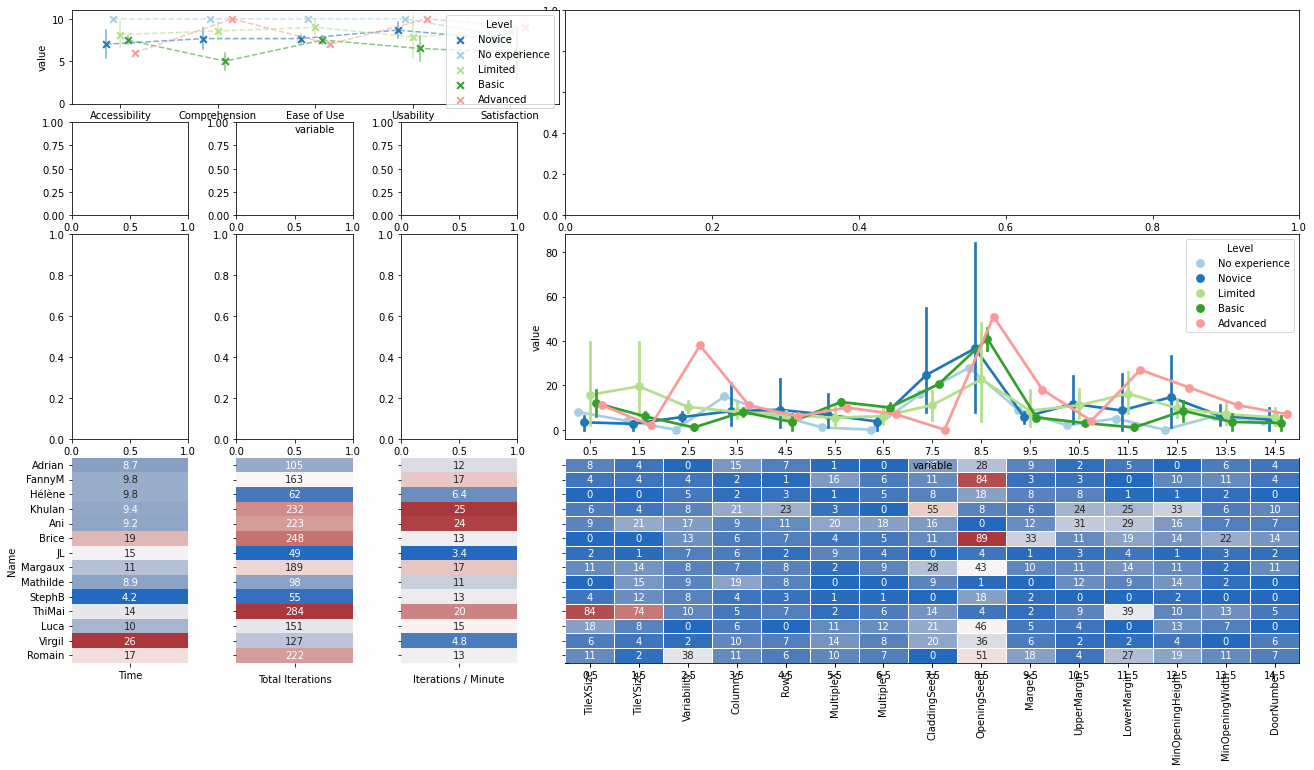

In [12]:
etudegen(0, iterations_df, time_iterations_df, studycolumns=['Time', 'Total Iterations', 'Iterations / Minute'], b=4, Title='Number of Iterations');

In [ ]:
etudegen(1, iterations_df.drop('Adrian', axis=0, level='Name'), time_iterations_df.drop('Adrian', axis=0, level='Name'), studycolumns=['Time', 'Total Iterations', 'Iterations / Minute'], b=8, Title='Number of Iterations', y2=0.1785);

In [ ]:
etudegen(2, iterations_df, time_iterations_df, studycolumns=['Time', 'Total Iterations', 'Iterations / Minute'], b=3, Title='Number of Iterations');

### Total 

In [ ]:
def Total(df1,studycolumn,_Title):
    df=df1.droplevel(['Order'])
    fig =plt.figure(figsize=(24,8),facecolor="#fefdfd")
    gs = GridSpec(4,40,figure=fig)
    ax1=fig.add_subplot(gs[1:3,:4])
    ax3=fig.add_subplot(gs[1:3,5:9])
    ax4=fig.add_subplot(gs[1:3,10:14])
    fig.suptitle(_Title+': Total',x=0.5,y=0.92,fontsize=20)
    ax9=fig.add_subplot(gs[3:,15:])
    ax2=fig.add_subplot(gs[:3,15:],sharex=ax9)
    ax5=fig.add_subplot(gs[3:,15:])
    ax6=fig.add_subplot(gs[3:,:4])
    ax7=fig.add_subplot(gs[3:,5:9])
    ax8=fig.add_subplot(gs[3:,10:14])
    ax10=fig.add_subplot(gs[:1,:4])
    ax11=fig.add_subplot(gs[:1,5:9])
    ax12=fig.add_subplot(gs[:1,10:14])

    a=(df.drop(['Average','Standard Deviation','Tot'],axis=0,level='Type'))
    ###Time

    # time2=df.drop(['Average','Standard Deviation','Tot'],axis=0,level='Type')
    if ('Time' in a.columns):a['Time']=a['Time'].apply(time_to_sec)
    b=a
    c=a
    d=a
    a=a.droplevel(['Level'])
    df=df.droplevel(['Level'])
    _color3=sns.mpl_palette("RdYlBu",3)
    ghtime=a[studycolumn[0]].xs('Grasshopper',level='Type').mean()
    hybridtime=a[studycolumn[0]].xs('Hybrid',level='Type').mean()
    plugintime=a[studycolumn[0]].xs('Plugin',level='Type').mean()
    av_time=pd.DataFrame([ghtime,hybridtime,plugintime],index=['Grasshopper','Hybrid','Plugin'],columns=[studycolumn[0]])
    sns.heatmap(av_time,ax=ax6,cbar=None,annot=True,cmap="vlag")
    ax6.set_yticklabels(['Grasshopper','Hybrid','Plugin'])
    
    double_plot(a, studycolumn[0], ax10, ax1,'Time in minutes', _color3,'Type', (lambda x:_type.index(x)))
    double_plot(a, studycolumn[1], ax11, ax3,'Tot Iterations', _color3,'Type', (lambda x:_type.index(x)))
    double_plot(a, studycolumn[2], ax12, ax4,'Iterations/min', _color3,'Type', (lambda x:_type.index(x)))

    ghtime=a[studycolumn[1]].xs('Grasshopper',level='Type').mean()
    hybridtime=a[studycolumn[1]].xs('Hybrid',level='Type').mean()
    plugintime=a[studycolumn[1]].xs('Plugin',level='Type').mean()
    av_time=pd.DataFrame([ghtime,hybridtime,plugintime],index=['Grasshopper','Hybrid','Plugin'],columns=[studycolumn[1]])
    sns.heatmap(av_time,ax=ax7,cbar=None,annot=True,cmap="vlag",fmt='g')
    ax7.set_yticklabels("")
    

    ###It/minute

    ghtime=a[studycolumn[2]].xs('Grasshopper',level='Type').mean()
    hybridtime=a[studycolumn[2]].xs('Hybrid',level='Type').mean()
    plugintime=a[studycolumn[2]].xs('Plugin',level='Type').mean()
    av_time=pd.DataFrame([ghtime,hybridtime,plugintime],index=['Grasshopper','Hybrid','Plugin'],columns=[studycolumn[2]])
    sns.heatmap(av_time,ax=ax8,cbar=None,annot=True,cmap="vlag",fmt='g')
    ax8.set_yticklabels("")
    

    ###
    av_gh=df.xs('Grasshopper',level='Type').drop(studycolumn,axis=1).mean()
    av_gh.name='GH'
    av_hyb=df.xs('Hybrid',level='Type').drop(studycolumn,axis=1).mean()
    av_hyb.name='Hybrid'
    av_plugin=df.xs('Plugin',level='Type').drop(studycolumn,axis=1).mean()
    av_plugin.name='Plugin'
    average=pd.DataFrame([av_gh,av_hyb,av_plugin],index=['GH','Hybrid','Plugin'])
    sns.heatmap(average,ax=ax9,cbar=None,annot=True,cmap="vlag",linewidth=0.5)
    sns.heatmap(average,ax=ax5,cbar=None,annot=True,cmap="vlag",linewidth=0.5)
    df=df.loc[:,['Grasshopper','Hybrid','Plugin'],:]
    locs=ax5.get_xticks()
    labels=ax5.get_xticklabels()
    gh=df.drop(studycolumn,axis=1)
    # gh=gh.droplevel(['Level'])
    gh.columns=locs
    gh=gh.reset_index(level='Type',drop=False)


    gh=gh.melt(id_vars=['Type'])
    sns.pointplot(x=gh['variable'],y=gh['value'],data=df,hue=gh['Type'],ax=ax2,palette="RdYlBu",dodge=0.2)
    # ax2.set_xticks(locs);
    ax2.set_xlabel(None)
    ax2.legend(loc='upper left')
    ax2.set_xticklabels("")
    ax2.set_frame_on(False)
    ax2.set_ylabel(None)
    # ax2.set_yticklabels("")
    ax5.set_xticklabels(labels)
    ax1.set_frame_on(False)
    ax1.grid(visible=True)
    ax3.set_frame_on(False)
    ax3.grid(visible=True)
    ax4.set_frame_on(False)
    ax4.grid(visible=True)
    ax9.set_yticklabels("")
    ax5.set_yticklabels("")
    return 1


studycolumn=['Time','Total Iterations','Iterations / Minute']
Total(iterations_df, studycolumn, 'Number of Iterations');

## Etude selon l'ordre

### Grasshopper

In [ ]:
#_color2=sns.mpl_palette('RdYlBu_r',3)

In [ ]:
def order_analysis(a,df,timedf,kplist,b,_Title):
    fig=plt.figure(figsize=(24,12))
    Title=str(_type[a - 1])
    fig.suptitle(_Title+": "+Title,y=0.94,fontsize=20)
    gs = GridSpec(4,12,figure=fig)
    ax1=fig.add_subplot(gs[:1,3:6])
    ax2=fig.add_subplot(gs[1:2,3:6])
    ax3=fig.add_subplot(gs[2:3,3:6])
    ax4=fig.add_subplot(gs[:4,:1])
    ax5=fig.add_subplot(gs[3:4,3:6])
    ax6=fig.add_subplot(gs[:4,1:2])
    ax7=fig.add_subplot(gs[:4,2:3])
    ax8=fig.add_subplot(gs[:1,9:])
    ax9=fig.add_subplot(gs[1:2,9:])
    ax10=fig.add_subplot(gs[2:3,9:])
    ax11=fig.add_subplot(gs[3:4,9:])
    ax12=fig.add_subplot(gs[:1,6:9])
    ax13=fig.add_subplot(gs[1:2,6:9])
    ax14=fig.add_subplot(gs[2:3,6:9])
    ax15=fig.add_subplot(gs[3:4,6:9])
    label=(_type[a - 1])
    keeplist=kplist
    resultat=df.reset_index('Level',drop=False)
    resultat['Level']=resultat['Level'].map(lambda x:x[b])
    resultat.sort_values('Level',axis=0,inplace=True)
    if ('Time' in resultat.columns):resultat['Time']=resultat['Time'].apply(time_to_sec)
    resultat=resultat.xs(label,level='Type')
    resGh=resEnq[resEnq['Type'] == _type[a - 1]]
    resGh['Level']=resGh['Level'].map(lambda x:x[b])
    ax=[ax1,ax2,ax3,ax4,ax6,ax7,ax8,ax9,ax10]
    for i in range(3):
        interaction_line_plot(ax[i], resultat, i, keeplist)
        box_plot(ax[i + 3], i, resultat, keeplist)
        plot_feedback(ax[i + 6], i, resGh)
    ax6.set_yticklabels("")
    ax7.set_yticklabels("")
    df=timedf.xs(_type[a - 1], level='Type').reset_index('Level', drop=False)
    df['Level']=df['Level'].map(lambda x:int(x[b]))
    df0level=df.xs(0,level='Order')['Level'].unique()
    df1level=df.xs(1,level='Order')['Level'].unique()
    df2level=df.xs(2,level='Order')['Level'].unique()
    dflevel=[df0level,df1level,df2level]
    df.set_index(['Level'],append=True,inplace=True)
    ax=[ax12,ax13,ax14]
    for i in range(3):
        time_level_plot(df, dflevel, i, ax[i], 3)
    df=df.droplevel('Level')
    for i in range(3):
        sns.regplot(x='variable',y='value',data=df.xs(i,level='Order').melt().applymap(lambda x:int(x)),ax=ax15,order=3,x_estimator=np.mean,scatter=False,color=_color2[i],ci=None)
    t=resultat.drop(keeplist,axis=1).drop(['Level'],axis=1)
    t=t.reset_index('Order',drop=False)
    t['Order']=t['Order'].map(lambda x:x+1)
    t=t.melt(id_vars='Order')
    sns.pointplot(x=t['variable'],y=t['value'],data=t,hue=t['Order'],palette='RdYlBu_r',ax=ax5,ci='sd',dodge=0.2)
    sns.pointplot(x='variable',y='value',data=resGh[resGh['Survey']=='B'],hue='Order',ci='sd',dodge=0.15,palette='RdYlBu_r',ax=ax11)
    ax11.set_ylabel(None)
    # ax11.grid(visible=True)
    ax11.get_legend().remove()
    ax11.set_xlabel(None)
    ax11.tick_params(axis='x',rotation=20)
    ax5.legend(loc='upper right')
    ax5.tick_params(axis='y',pad=-1)
    ax5.set_xticklabels("")
    ax5.set_xlabel('Parameter')
    ax5.set_title('Average by Interaction order',loc='left',y=1,pad=3)
    return

In [ ]:
keeplist1 =['Time','Total Iterations','Iterations / Minute']
order_analysis(1, iterations_df, time_iterations_df, keeplist1, 4, 'Number of Iterations')

### Hybrid

In [ ]:
order_analysis(2, iterations_df.drop('Adrian', axis=0, level='Name'), time_iterations_df.drop('Adrian', axis=0, level='Name'), keeplist1, 8, 'Number of Iterations')

### Plugin

In [ ]:
order_analysis(3, iterations_df, time_iterations_df, keeplist1, 3, 'Number of Iterations')

# Phases

In [ ]:
#Iterations.round(decimals=1)
#ax = plt.subplot(111, frame_on=False)
#ax.xaxis.set_visible(False)  # hide the x axis
#ax.yaxis.set_visible(False)
#ax.figure.set_figwidth(22)
#v=table(ax,Iterations,loc='top')
with pd.option_context('display.max_rows', None, 'display.max_columns', 12,'display.max_colwidth',50):
    display(phase_df.round(decimals=2))
iterations_df.round(decimals=2).to_excel('output/testexcel.xlsx')

## Étude Générale

### Grasshopper

In [ ]:
etudegen(0, phase_df, time_phases_df, studycolumns=['Time', 'Total', 'Max'], b=4, Title='Number of modification phases');

In [ ]:
etudegen(1, phase_df.drop('Adrian', axis=0, level='Name'), time_phases_df.drop('Adrian', axis=0, level='Name'), studycolumns=['Time', 'Total', 'Max'], b=8, Title='Number of modification phases', y2=0.1785);

### Plugin

In [ ]:
etudegen(2, phase_df, time_phases_df, studycolumns=['Time', 'Total', 'Max'], b=3, Title='Number of modification phases');

### Total 

In [ ]:
Total(phase_df, ['Time', 'Total', 'Max'], 'Number of modification phases');

## Etude selon l'ordre

### Grasshopper

In [ ]:
keeplist2 =['Time','Total','Max']
order_analysis(1, phase_df, time_phases_df, keeplist2, 4, 'Number of modification phases')

### Hybrid

In [ ]:
order_analysis(2, phase_df.drop('Adrian', axis=0, level='Name'), time_phases_df.drop('Adrian', axis=0, level='Name'), keeplist2, 8, 'Number of modification phases')

### Plugin

In [ ]:
order_analysis(3, phase_df, time_phases_df, keeplist2, 3, 'Number of modification phases')

# Unique

In [ ]:
#Iterations.round(decimals=1)
#ax = plt.subplot(111, frame_on=False)
#ax.xaxis.set_visible(False)  # hide the x axis
#ax.yaxis.set_visible(False)
#ax.figure.set_figwidth(22)
#v=table(ax,Iterations,loc='top')
with pd.option_context('display.max_rows', None, 'display.max_columns', 12,'display.max_colwidth',50):
    display(unique_df.round(decimals=2))
unique_df.round(decimals=2).to_excel('output/testexcel-unique.xlsx')

## Étude Générale

### Grasshopper

In [ ]:
etudegen(0, unique_df, time_unique_df, studycolumns=['CV', 'Total', 'Max'], b=4, Title='Number of unique values', y2=0.1785);

In [ ]:
etudegen(1, unique_df.drop('Adrian', axis=0, level='Name'), time_unique_df.drop('Adrian', axis=0, level='Name'), studycolumns=['CV', 'Total', 'Max'], b=8, Title='Number of unique values', y2=0.1825);

### Plugin

In [ ]:
etudegen(2, unique_df, time_unique_df, studycolumns=['CV', 'Total', 'Max'], b=3, Title='Number of unique values', y2=0.1785);

### Total 

In [ ]:
Total(unique_df, ['CV', 'Total', 'Max'], 'Number of unique values');

## Etude selon l'ordre

### Grasshopper

In [ ]:
keeplist3 =['CV','Total','Max']
order_analysis(1, unique_df, time_unique_df, keeplist3, 4, 'Number of unique values')

### Hybrid

In [ ]:
order_analysis(2, unique_df.drop('Adrian', axis=0, level='Name'), time_unique_df.drop('Adrian', axis=0, level='Name'), keeplist3, 8, 'Number of unique values')

### Plugin

In [ ]:
order_analysis(3, unique_df, time_unique_df, keeplist3, 3, 'Number of unique values')

In [ ]:
phase_df.round(decimals=2)

In [ ]:
Iterations2=iterations_df.drop(['Time'], axis=1)
meangh=pd.DataFrame(Iterations2.xs("Grasshopper",level="Type").mean()).T
meangh.index=['GH']
mean=meangh
meanhyb=pd.DataFrame(Iterations2.xs("Hybrid",level="Type").mean()).T
meanhyb.index=['Hybrid']
mean=mean.append(meanhyb)
meanplg=pd.DataFrame(Iterations2.xs("Plugin",level="Type").mean()).T
meanplg.index=['Plugin']
mean=mean.append(meanplg)
mean = mean.round(decimals=2)
mean.T.plot(figsize=(24,6),title='Average');

In [ ]:
Phases2=phase_df.drop(['Time'], axis=1)
meangh=pd.DataFrame(Phases2.xs("Grasshopper",level="Type").mean()).T
meangh.index=['GH']
mean=meangh
meanhyb=pd.DataFrame(Phases2.xs("Hybrid",level="Type").mean()).T
meanhyb.index=['Hybrid']
mean=mean.append(meanhyb)
meanplg=pd.DataFrame(Phases2.xs("Plugin",level="Type").mean()).T
meanplg.index=['Plugin']
mean=mean.append(meanplg)
mean.T.plot(figsize=(24,6))
mean.round(decimals=2);